# Andromeda in Jupyter

### Interactive Inverse Dimension Reduction 

This notebook implements interactive dimension reduction (DR) for exploratory analysis of high-dimensional data.
It uses a Multi-Dimensional Scaling (MDS) algorithm with a weighted distance metric. It enables both forward and inverse DR interaction. 

**MDS** projects high-dimensional data to a 2D scatterplot. A **weighted distance function** with user-specified weights on each dimension enables alternative projections that emphasize different dimensions. An **Inverse-DR** algorithm learns distance function weights for  user-constructed layouts of the data points.

### Instructions:

1. Run All
1. Proceed to the interactive plots near the bottom
1. There are three kinds of interactions:
    1. Select points in the DR plot and click Details to see data values.
    1. **Parametric interaction:** Adjust the weight sliders and click Apply to alter the projection plot.
    1. **Projection interaction:** Drag points in the projection plot, then click Learn to see learned weights, and click Copy to see the updated projection plot.
1. Be patient, its interactive matplotlib in python and Jupyter!

### Credits:

Authors: Han Liu and Chris North, Dept of Computer Science, Virginia Tech.

Based on: *Self JZ, Dowling M, Wenskovitch J, Crandell I, Wang M, House L, Leman S, North C. Observation-Level and Parametric Interaction for High-Dimensional Data Analysis. ACM Transactions on Interactive Intelligent Systems.  8(2), 2018.* https://infovis.cs.vt.edu/sites/default/files/observation-level-parametric_first_look_version.pdf


In [1]:
%matplotlib notebook

# interactive notebook format is required for the interactive plot

import numpy as np
import pandas as pd
import math
import random
import os
import cv2
import csv
import shutil
import time

from os import listdir
from os.path import isfile, join
from math import isnan

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import sklearn.metrics.pairwise

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from functools import partial
import ipywidgets as widgets
from ipywidgets import interact, Layout
from IPython.display import display, display
from IPython.display import Image
from ipywidgets import interact
import ipyplot

# Import modules for model

In [2]:
from torchvision import models, datasets
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
figsize(20, 40)
modelInit = models.resnet18(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
class new_model(nn.Module):
    def __init__(self,output_layer = None):
        super().__init__()
        self.pretrained = models.resnet18(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self,x):
        x = self.net(x)
        return x

In [4]:
def DNNfeatures(img,output_layer = 'layer1'):
    model = new_model(output_layer = output_layer)
    transf = transforms.Compose(
        [
            ## Scaling to [0.0,1.0]
            transforms.ToTensor(),
            transforms.Resize([224, 224])
        ]
    )
    img_tensor = transf(img)
    transf2 = transforms.Compose(
        [
            transforms.ToTensor(),
            
            ## Using the mean and std of Imagenet is a common practice. 
            ## If you want to train from scratch on your own dataset, you can calculate the new mean and std. 
            ## Otherwise, using the Imagenet pretrianed model with its own mean and std is recommended.
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ]
    )

    img_tensor2 = transf2(img)
    img = img_tensor2.unsqueeze(0)
    out = model(img)
#     print(out.shape)

    output = F.avg_pool2d(out, kernel_size=out.shape[2], stride=out.shape[2])
#     print(output.shape)
    output = output.cpu().data.numpy()
    return output.flatten()

In [5]:
def batchExtractDNN(inputDir):
    imread_failed = []
    features = []
    index = []
    df = pd.DataFrame(columns = range(1,65))
    for (path,dirname,filenames) in os.walk(inputDir):
        for image in filenames:
            try:
                src = path + image
                imgName = image.split('.')[0]
                img = cv2.imread(src)
                feature = DNNfeatures(img) 
                features.append(feature)
                index.append(imgName)
                df = pd.DataFrame(features,columns = range(1, 65), index=index)
                df.index.name = 'Image'
            except:
                imread_failed.append(image)
    display(df)
    return df

# Load and Pre-process Data

Change the **filename** to load a dataset.  CSV data file is expected to have a first column 'Name' that is used as the index, and header row of column names.  Numeric columns are used for projection.

In [6]:
numClasses = 3
mypath = r"./dataPointMonitor/"
finalDir = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]
imageNames = []
for path in finalDir:
    imageNames.append(os.path.basename(os.path.normpath(path)))

In [7]:
# filename = './csvFiles/ResNetFeaturesLayer1_batch5.csv'
# df = pd.read_csv(filename)
df = batchExtractDNN('../testTrainingData_batch5/')
paths =  list(df.index.values)
paths[:] = map(lambda x: "./testTrainingData/" + x + ".jpg", paths) 

/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_util

/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_util

/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_util

/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_util

/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/torchvision/models/_util

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
Image,,,,,,,,,,,,,,,,,,,,,
2098late4,0.339517,0.291547,0.162358,0.064388,0.587803,0.037345,0.111468,0.075703,0.987605,0.039119,...,0.108705,0.399921,0.055545,0.185117,0.370863,0.551003,0.494571,0.887763,0.081648,0.720653
2076late6,0.338530,0.308715,0.179340,0.071691,0.591578,0.051619,0.114702,0.095706,0.985919,0.053232,...,0.112354,0.404801,0.076272,0.206873,0.395597,0.593404,0.509958,0.888326,0.093060,0.753469
2144disease7,0.328309,0.285897,0.176462,0.075366,0.573951,0.086099,0.211587,0.090238,0.993425,0.081689,...,0.125171,0.384493,0.073592,0.190757,0.387186,0.550013,0.486410,0.883927,0.114288,0.699875
2076late5,0.339168,0.303351,0.179345,0.069815,0.583201,0.056444,0.123896,0.094042,0.999338,0.052537,...,0.131869,0.396427,0.079784,0.198248,0.391309,0.567191,0.504098,0.885724,0.098223,0.741768
2044ready5,0.339681,0.280201,0.151955,0.044284,0.590341,0.024951,0.168339,0.055667,0.989330,0.037481,...,0.088746,0.400813,0.036967,0.170554,0.355940,0.545706,0.506054,0.884931,0.074592,0.710949
2039ready13,0.341470,0.286126,0.164103,0.050477,0.590832,0.029984,0.185329,0.065372,0.989472,0.041773,...,0.103020,0.403648,0.046239,0.180760,0.366019,0.548685,0.501434,0.884046,0.080611,0.715204
2039ready12,0.332183,0.289508,0.162178,0.054746,0.591590,0.042999,0.197835,0.070608,0.979908,0.054481,...,0.096322,0.397116,0.055557,0.181546,0.383050,0.571794,0.514674,0.884047,0.087322,0.719176
2038ready3,0.340481,0.280620,0.164270,0.056771,0.588629,0.037753,0.189215,0.067001,0.990108,0.047736,...,0.106277,0.403931,0.052223,0.181614,0.371837,0.549456,0.498676,0.886145,0.087674,0.715070
2063ready6,0.341305,0.288731,0.170104,0.052673,0.591654,0.033503,0.185233,0.066291,0.993253,0.042127,...,0.102875,0.400365,0.050811,0.184931,0.373631,0.555618,0.504512,0.888008,0.079895,0.725467


In [8]:
display(df.shape)
df.head(5)

(60, 64)

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
Image,,,,,,,,,,,,,,,,,,,,,
2098late4,0.339517,0.291547,0.162358,0.064388,0.587803,0.037345,0.111468,0.075703,0.987605,0.039119,...,0.108705,0.399921,0.055545,0.185117,0.370863,0.551003,0.494571,0.887763,0.081648,0.720653
2076late6,0.338530,0.308715,0.179340,0.071691,0.591578,0.051619,0.114702,0.095706,0.985919,0.053232,...,0.112354,0.404801,0.076272,0.206873,0.395597,0.593404,0.509958,0.888326,0.093060,0.753469
2144disease7,0.328309,0.285897,0.176462,0.075366,0.573951,0.086099,0.211587,0.090238,0.993425,0.081689,...,0.125171,0.384493,0.073592,0.190757,0.387186,0.550013,0.486410,0.883927,0.114288,0.699875
2076late5,0.339168,0.303351,0.179345,0.069815,0.583201,0.056444,0.123896,0.094042,0.999338,0.052537,...,0.131869,0.396427,0.079784,0.198248,0.391309,0.567191,0.504098,0.885724,0.098223,0.741768
2044ready5,0.339681,0.280201,0.151955,0.044284,0.590341,0.024951,0.168339,0.055667,0.989330,0.037481,...,0.088746,0.400813,0.036967,0.170554,0.355940,0.545706,0.506054,0.884931,0.074592,0.710949


In [9]:
# Use 'Name' column as index
#df.rename(columns={df.columns[0]:'Name'}, inplace=True)
# df.set_index('Image', inplace=True)

# Sort rows and columns
# df.sort_index(axis=1, inplace=True)
df.sort_index(inplace=True)

df_numeric = df.select_dtypes(include='number')  #'int32' or 'int64' or 'float32' or 'float64'
df_category = df.select_dtypes(exclude='number') #'object'

# Z-score normalization
# normalized_df = (df_numeric - df_numeric.mean()) / df_numeric.std()
normalized_df = df_numeric  # do not normalize animal dataset, all columns are 0-100 scale

print('Data size (r,c) =', df_numeric.shape)
df_numeric.head(5)

Data size (r,c) = (60, 64)


,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
Image,,,,,,,,,,,,,,,,,,,,,
2024ready2,0.327290,0.271136,0.146217,0.053589,0.590181,0.029524,0.174781,0.049342,0.972820,0.045145,...,0.080452,0.396753,0.040451,0.170348,0.369257,0.557963,0.510781,0.882484,0.084860,0.700252
2028ready4,0.337819,0.298921,0.165496,0.052658,0.596392,0.041538,0.188324,0.073292,0.984579,0.044105,...,0.088059,0.402111,0.049329,0.188118,0.379542,0.571938,0.521082,0.885504,0.083098,0.735904
2029ready20,0.332158,0.286105,0.154481,0.051370,0.593501,0.032536,0.180415,0.062255,0.976921,0.045467,...,0.087420,0.399208,0.046781,0.180986,0.383204,0.566279,0.512529,0.885490,0.082679,0.719796
2031ready1,0.344045,0.296453,0.166585,0.051104,0.592781,0.041753,0.188585,0.070446,0.994566,0.043881,...,0.099731,0.400551,0.064217,0.186190,0.378241,0.557465,0.510693,0.885704,0.081687,0.725112
2033ready9,0.327524,0.284593,0.151776,0.049636,0.592493,0.029253,0.180878,0.052809,0.978324,0.048543,...,0.079937,0.397857,0.045527,0.170111,0.367450,0.564600,0.518553,0.885392,0.078063,0.706053


#  Dimension Reduction Model:  Weighted MDS

For DR, we use the Multi-Dimensional Scaling (MDS) algorithm on a weighted data space. **Dimension weights** are applied to the high-dimensional (HD) data.  Weights are normalized to sum to 1, so as to normalize the HD distances to roughly constant size space independent of p.

The **distance function for the high-dimensional (HD) data** is L1 manhattan distance. L1 is good for general purpose use with multi-dimensional quantitative datasets. 

The **distance function for the 2D projected points** is L2 Euclidean distance, which makes sense for human percpetion in the plot.

In [10]:
# Compute the distance matrix for the weighted high-dimensional data using L1 distance function.
#  Input HD data should already be weighted.
def distance_matrix_HD(dataHDw):  # dataHDw (pandas or numpy) -> distance matrix (numpy)
    dist_matrix = sklearn.metrics.pairwise.manhattan_distances(dataHDw)
    #m = pd.DataFrame(m, columns=dataHD.index, index=dataHD.index)  # keep as np array for performance
    return dist_matrix


# Compute the distance matrix for 2D projected data using L2 distance function.
def distance_matrix_2D(data2D):  # data2d (pandas or numpy) -> distance matrix (numpy)
    dist_matrix = sklearn.metrics.pairwise.euclidean_distances(data2D) 
    #m = pd.DataFrame(m, columns=data2D.index, index=data2D.index) # keep as np array for performance
    return dist_matrix


#def dist(x,y):
#    return np.linalg.norm(x-y, ord=2)

**MDS** projects the weighted high-dimensional data to 2D. Tune the algorithm's parameters for performance.

In [11]:
# Calculate the MDS stress metric between HD and 2D distances.  Uses numpy for efficiency.
def stress(distHD, dist2D):  #  distHD, dist2D (numpy) -> stress (float)
    #s = np.sqrt((distHD-dist2D).pow(2).sum().sum() / distHD.pow(2).sum().sum())  # pandas
    #s = np.sqrt(((distHD-dist2D)**2).sum() / (distHD**2).sum())   # numpy
    s = ((distHD-dist2D)**2).sum() / (distHD**2).sum()   # numpy, eliminate sqrt for efficiency
    return s

def compute_mds(dataHDw):  # dataHDw -> data2D (pandas)
    distHD = distance_matrix_HD(dataHDw)
    # Adjust these parameters for performance/accuracy tradeoff
    mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=10, max_iter=1000)
    # Reduction algorithm happens here:  data2D is nx2 matrix
    data2D = mds.fit_transform(distHD)
    
    # Rotate the resulting 2D projection to make it more consistent across multiple runs.
    # Set the 1st PC to the y axis, plot looks better to spread data vertically with horizontal text labels
    pca = sklearn.decomposition.PCA(n_components=2)
    data2D = pca.fit_transform(data2D)
    data2D = pd.DataFrame(data2D, columns=['y','x'], index=dataHDw.index)
    
    data2D.stress_value = stress(distHD, distance_matrix_2D(data2D))
    return data2D

def dimension_reduction(dataHD, wts): # dataHD, wts -> data2D (pandas)
    # Normalize the weights to sum to 1
    wts = wts/wts.sum()
    
    # Apply weights to the HD data 
    dataHDw = dataHD * wts
    
    # DR algorithm
    data2D = compute_mds(dataHDw)

    # Compute row relevances as:  data dot weights
    # High relevance means large values in upweighted dimensions
    data2D['relevance'] = dataHDw.sum(axis=1)
    return data2D

min_weight, max_weight = 0.00001, 0.9999
init_weight = min_weight  # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
weights = pd.Series(init_weight, index=normalized_df.columns, name="Weight")  # the current weight list

df_2D = dimension_reduction(normalized_df, weights)   # the current projected data

In [12]:
weights.head(2)

1    0.00001
2    0.00001
Name: Weight, dtype: float64

In [13]:
pd.DataFrame(distance_matrix_HD(normalized_df * (weights/weights.sum())), 
             columns=normalized_df.index, index=normalized_df.index).head(2)

Image,2024ready2,2028ready4,2029ready20,2031ready1,2033ready9,2034ready5,2036ready18,2038ready15,2038ready3,2039ready12,...,2147disease15,2147disease2,2147disease4,2147disease5,2147disease6,2147disease7,2148disease11,2148disease12,2148disease13,2148disease17
Image,,,,,,,,,,,,,,,,,,,,,
2024ready2,0.000000,0.014817,0.007793,0.014664,0.004628,0.014064,0.014486,0.014598,0.012420,0.012231,...,0.014081,0.018788,0.020687,0.015342,0.017623,0.029057,0.014747,0.022610,0.017840,0.024563
2028ready4,0.014817,0.000000,0.007290,0.005998,0.012253,0.007679,0.006655,0.007463,0.008901,0.007075,...,0.016594,0.018687,0.020738,0.020456,0.017686,0.024245,0.015952,0.018309,0.016767,0.020591


In [14]:
print(df_2D.stress_value)
df_2D.head(5)

0.018622541178221125


,y,x,relevance
Image,,,
2024ready2,-0.015065,-0.002165,0.345462
2028ready4,-0.004893,0.009859,0.359666
2029ready20,-0.009236,0.004287,0.352789
2031ready1,-0.003835,0.007864,0.359693
2033ready9,-0.012403,-0.000419,0.348086


In [15]:
def centroid(df_2D,cat):
    x_coords = df_2D[df_2D.label==cat].x.values
    y_coords = df_2D[df_2D.label==cat].y.values
    _len = len(df_2D)
    centroid_x = sum(x_coords)/_len
    centroid_y = sum(y_coords)/_len
    return (centroid_x, centroid_y)

def var(*centroids):
    x = [c[0] for c in centroids]
#     print("x: ",x)
    y = [c[1] for c in centroids]
    _len = len(centroids)
#     print(_len)
#     print("sum x: ",sum(x))
    new_centroids_x = np.mean(x)
#     print(new_centroids_x)
    new_centroids_y = np.mean(y)
    var = sum((x - new_centroids_x)) ** 2 + sum((y - new_centroids_y)) ** 2
#     print(x - new_centroids_x)
#     print(_len)
    return var

# labels_df = df_2D.index.str.extract(r'([a-z]+)')
# labels_df.index = df_2D.index
# df_2D['label'] = labels_df

# ready_centroid = centroid(df_2D,'ready')
# disease_centroid = centroid(df_2D,'disease')
# late_centroid = centroid(df_2D,'late')

# var(ready_centroid,disease_centroid,late_centroid)

# Inverse Dimension-Reduction Learning Algorithm

Computes the inverse-Dimension-Reduction: given input 2D points, compute new weights.
Optimizes the MDS stress function that compares 2D pairwise distances (||$x_i-x_j||$) to weighted HD pairwise distances ($d_{ij}$):
![Stress](https://wikimedia.org/api/rest_v1/media/math/render/svg/7989b3afc0d8795a78c1631c7e807f260d9cfe68)

Technically, we compute the inverse weighted distance function. We shortcut the optimization by eliminating MDS from the process, and assume that the user input 2D distances are actually the desired HD distances, not the 2D distances after re-projection. Thus, given the input (HD) distances, we find weights that would produce these distances in the HD space.

In [16]:
# This method is used to propose a new weight for current column in a smart fashion
def new_proposal(current, step, direction):
    return np.clip(current + direction*step*random.random(), 0.00001, 0.9999)

# Repeatedly tries to modify each dim weight to see if it improves the stress, thus
# getting the weighted high-dim distances to more closely match the input 2D distances.
#   dataHD = high-dim data, as pandas
#   data2D = 2D data input, as pandas
#   weights = as pandas series, or None for weights[i]=1/p
def inverse_DR(dataHD, data2D, curWeights=None):  # -> new weights, as Series
    dist2D = distance_matrix_2D(data2D)  # compute 2D distances only once
    col_names = dataHD.columns
    dataHD = dataHD.to_numpy()  # use numpy for efficiency
    row, col = dataHD.shape
    
    if curWeights==None:
        curWeights = np.array([1.0/col]*col)  # default weights = 1/p
    else:
        curWeights = curWeights.to_numpy()
        curWeights = curWeights / curWeights.sum()  # Normalize weights to sum to 1
    newWeights = curWeights.copy()  # re-use this array for efficiency
    
    # Initialize state
    flag = [0]*col         # degree of success of a weight change
    direction = [1]*col  # direction to move a weight, pos or neg
    step = [1.0/col]*col   # how much to change each weight
    
    dataHDw = dataHD * curWeights   # weighted space, re-use this array for efficiency
    distHD = distance_matrix_HD(dataHDw)
    curStress = stress(distHD, dist2D)
    print('Starting stress =', curStress, 'Processing...')

    MAX = 500   # default setting of the number of iterations

    # Try to minorly adjust each weight to see if it reduces stress
    for i in range(MAX):
        for dim in range(col):            
            # Get a new weight for current column
            nw = new_proposal(curWeights[dim], step[dim], direction[dim])
            
            # Scale the weight list such that it sums to 1
            #newWeights = curWeights.copy()  # avoid extra copy op using math below
            #newWeights[dim] = nw
            #newWeights = newWeights / s
            s = 1.0  + nw - curWeights[dim]   # 1.0 == curWeights.sum()
            np.true_divide(curWeights, s, out=newWeights)  # transfers to other array, while doing /
            newWeights[dim] = nw / s
            
            # Apply new weights to HD data
            np.multiply(dataHD, newWeights, out=dataHDw)  # dataHDw = dataHD * newWeights; efficiently reuses dataHDw array
            distHD = distance_matrix_HD(dataHDw)

            # Get the new stress
            newStress = stress(distHD, dist2D)
            
            # If new stress is lower, then update weights and flag this success
            if newStress < curStress:
                temp = curWeights
                curWeights = newWeights
                newWeights = temp   # reuse the old array next iteration
                curStress = newStress
                flag[dim] = flag[dim] + 1
            else:
                flag[dim] = flag[dim] - 1
                direction[dim] = -direction[dim]  # Reverse course
    
            # If recent success, then speed up the step rate
            if flag[dim] >= 5:
                step[dim] = step[dim] * 2
                flag[dim] = 0
            elif flag[dim] <= -5:
                step[dim] = step[dim] / 2
                flag[dim] = 0
                
    print('Solution stress =', curStress, 'Done.')
    #print("weight", curWeights)
    #print("flag", flag)
    #print("dir", direction)
    #print("step", step)
    return pd.Series(curWeights, index=col_names, name="Weight")


# Retrain the model

## Start with preprocessing the data

### Define the model 

In [17]:
vgg_model = tf.keras.applications.vgg16.VGG16()
#model.summary()

Metal device set to: Apple M1 Pro


2022-08-23 23:36:49.893121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-23 23:36:49.893251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Amend the top most layer

In [56]:
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)
    layer.trainable = False #We should only be training the top most layer
# model.add(layers.Dense(numClasses))
model.add(layers.Dense(64))

#model.summary()

In [19]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [43]:
def file_setup(retrain_df, folder_name):
    if type(retrain_df) == None or retrain_df.empty:
        return
    
    current_dir = os.getcwd()
    
    #Create a folder to store all of the datasets (the folder will be empty)
    if os.path.exists("./" + folder_name):
        shutil.rmtree("./" + folder_name)
        os.chdir(current_dir)

    os.mkdir(folder_name)
    
    # Make 2 folders called train and test
    os.chdir(folder_name)
    os.mkdir("train")
    os.mkdir("test")
    os.mkdir("val")
    
    #Create a folder for each class in train
    os.chdir("./train")
    train_dir = os.getcwd()
    for i in retrain_df['Class'].unique():
        os.mkdir(str(i))
    class_names = os.listdir('./')
    train_class_dir = os.listdir('./')
    
    #Create a folder for each class in test
    os.chdir("../test")
    test_dir = os.getcwd()
    for i in retrain_df['Class'].unique():
        os.mkdir(str(i))
    test_class_dir = os.listdir('./')
    
    #Create a folder for each class in val
    os.chdir("../val")
    val_dir = os.getcwd()
    for i in retrain_df['Class'].unique():
        os.mkdir(str(i))
    test_class_dir = os.listdir('./')
    
    #Split each class to its train and test data
    os.chdir("../")
    for i in retrain_df['Class'].unique():
        sub_df = retrain_df[retrain_df["Class"] == i]
        num_dataPoints = len(sub_df)
        num_train = math.floor(0.8*num_dataPoints)
        num_val = 1
        num_test = num_dataPoints - num_train - num_val
        
        
        #Populate the files
        counter = 0 #May not be the best approach for optimization
        for path in sub_df['Image_Path']:
            file = os.path.basename(path)
            file_path = current_dir + '/imagePreProcessing/' + file
            if counter < num_train:
                shutil.copyfile(file_path, "./train/" + str(i) + "/" +  file)
            elif counter > num_train and counter < num_train + num_test:
                shutil.copyfile(file_path, "./test/" + str(i) + "/" + file)
            else:
                shutil.copyfile(file_path, "./val/" + str(i) + "/" +  file)
            counter += 1
        
    
    os.chdir(current_dir)
    return [train_dir, test_dir, val_dir, class_names]

In [109]:
def retrain_model(retrain_df, folder_name):
    
    file_tree = file_setup(retrain_df, folder_name)
    train_dir = file_tree[0]
    test_dir = file_tree[1]
    val_dir = file_tree[2]
    class_names = file_tree[3]
    
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optim = keras.optimizers.Adam(lr=0.001)
    metrics = ["accuracy"]

    model.compile(optimizer=optim, loss=loss, metrics=metrics)
    
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
    
    train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
    valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
    test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

    train_batches = train_gen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        class_mode='sparse',
        batch_size=4,
        shuffle=True,
        color_mode="rgb",
        classes=class_names   
    )

    val_batches = valid_gen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        class_mode='sparse',
        batch_size=4,
        shuffle=True,
        color_mode="rgb",
        classes=class_names
    )

    test_batches = test_gen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        class_mode='sparse',
        batch_size=4,
        shuffle=False,
        color_mode="rgb",
        classes=class_names
    )
    
    epochs = 30

    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=2
    )

    model.fit(train_batches, validation_data=val_batches,
              callbacks=[early_stopping],
              epochs=epochs, verbose=2)
    new_weights = model.layers[-1].weights[-1].numpy()
    return (new_weights - np.min(new_weights))/np.ptp(new_weights)

In [23]:
# def retrain_model(retrain_df, folder_name, model):
#     file_tree = file_setup(retrain_df, folder_name)
#     train_dir = file_tree[0]
#     test_dir = file_tree[1]

#     train_dataset = datasets.ImageFolder(train_dir, transforms_train)
#     test_dataset = datasets.ImageFolder(test_dir, transforms_test)
#     train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)
#     test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)
    
#     num_features = model.fc.in_features     #extract fc layers features
#     model.fc = nn.Linear(num_features, numClasses)
#     model = model.to(device) 
#     criterion = nn.CrossEntropyLoss()  #(set loss function)
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
#     num_epochs = 1  #(set no of epochs)
#     start_time = time.time() #(for showing time)
#     for epoch in range(num_epochs): #(loop for every epoch)
#         print("Epoch {} running".format(epoch)) #(printing message)
#         """ Training Phase """
#         model.train()    #(training model)
#         running_loss = 0.   #(set loss 0)
#         running_corrects = 0 
#         # load a batch data of images
#         for i, (inputs, labels) in enumerate(train_dataloader):
#             inputs = inputs.to(device)
#             labels = labels.to(device) 
#             # forward inputs and get output
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)
#             # get loss value and update the network weights
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
#         epoch_loss = running_loss / len(train_dataset)
#         epoch_acc = running_corrects / len(train_dataset) * 100.
#         print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

#         """ Testing Phase """
#         model.eval()
#         with torch.no_grad():
#             running_loss = 0.
#             running_corrects = 0
#             for inputs, labels in test_dataloader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             epoch_loss = running_loss / len(test_dataset)
#             epoch_acc = running_corrects / len(test_dataset) * 100.
#             print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
#     save_path = 'custom-classifier_resnet_18_final_60_last_tr_epochs.pth'
#     torch.save(model.state_dict(), save_path)
#     return model._modules['layer1'][0]._modules['bn1'].weight.data

# Visualization and UI code

Use these functions to create the GUI components in any cell.

## Sliders

In [24]:
def create_sliders(wts):
    # Create sliders, one for each dimension weight
    style = {'description_width': 'initial'}
    sliders = [widgets.FloatSlider(min=min_weight, max=max_weight, step=0.01, value=value, 
                                       description=str(label), style = style, 
                                   continuous_update=False, readout_format='.5f',
                                  layout=Layout(width='60%', height='80px'))
                   for (label, value) in wts.iteritems()]
    # Display sliders
    for s in sliders:
        display(s)
    return sliders

def create_slider_buttons(sliders, thresh=20, version=None): 
    create_slider_buttons.thresh = thresh
    apply_button = widgets.Button(description='Apply Slider Weights')
    reset_button = widgets.Button(description='Reset Plot')
    download_impbutton = widgets.Button(description='Save Important Weights')
    download_allbutton = widgets.Button(description='Save Weights')
    load_button = widgets.Button(description='Load Weights')
    


    # Callback functions
    def apply_button_clicked(change):
        # Use the slider values to re compute the DR and redraw the plot
        global weights, df_2D, paths   # Update weights and df_2D globals
        weights = pd.Series([s.value for s in sliders], index=normalized_df.columns, name='Weight')
        df_2D = dimension_reduction(normalized_df, weights)   
        
        # Re-draw the plot
        draw_plot(plot_ax, df_2D, paths, point_attribute[0].value)
    apply_button.on_click(apply_button_clicked)

    def reset_button_clicked(change):
        # Reset all sliders to initial value and re-compute DR and re-draw the plot
        for s in sliders:
            s.value = init_weight
        apply_button_clicked(change)
    reset_button.on_click(reset_button_clicked)
    
    def download_impbutton_clicked(change):
        # Download .csv file with reletively important weights
        thresh = create_slider_buttons.thresh
        csv_columns = ['Index','Weight']
        csv_file = "SliderWeights.csv"
        slider_dict = {}
        final_slider_dict = {}
        for s in sliders:
            slider_dict[s.description] = s.value
            
        for key in slider_dict.keys():
            if slider_dict[key] > (thresh/100)*max(slider_dict.values()):
                final_slider_dict[key] = slider_dict[key]
        (pd.DataFrame.from_dict(data=final_slider_dict, orient='index')
         .to_csv(csv_file, header=True))     
    download_impbutton.on_click(download_impbutton_clicked)
    
    def download_allbutton_clicked(change):
        newpath = r'./WeightsDirectory' 
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        list_of_files = sorted( filter( lambda x: os.path.isfile(os.path.join(newpath, x)),
                        os.listdir(newpath)))
        if list_of_files[-1][-5].isnumeric() == False:
            version_number = 0
        else:
            version_number = int(list_of_files[-1][-5]) + 1

        # Download .csv file with reletively important weights
        thresh = create_slider_buttons.thresh
        csv_columns = ['Index','Weight']
        csv_file = "./WeightsDirectory/AllSliderWeights_Version_{version}.csv".format(version = str(version_number))
        slider_dict = {}
        for s in sliders:
            slider_dict[s.description] = s.value
        (pd.DataFrame.from_dict(data=slider_dict, orient='index')
          .to_csv(csv_file, header=True))     
    download_allbutton.on_click(download_allbutton_clicked)
    
    def load_button_clicked(change):   
        newpath = r'./WeightsDirectory' 
        list_of_files = sorted( filter( lambda x: os.path.isfile(os.path.join(newpath, x)),
                        os.listdir(newpath)))
        file_exists = False
        for file in list_of_files:
            if file[-5] != 'S' and int(file[-5]) == version:
                file_exists = True
                break
        if file_exists == False:
            print("Version not found")
            return
        
        filename = "./WeightsDirectory/AllSliderWeights_Version_{versionNum}.csv".format(versionNum = str(version)) 
        dict_from_csv_un = pd.read_csv(filename, header=None, index_col=0, squeeze=True).to_dict()
        dict_from_csv = {k: dict_from_csv_un[k] for k in dict_from_csv_un if not isnan(k)}
        
        for s in sliders:
            s.value = dict_from_csv[float(s.description)]
    load_button.on_click(load_button_clicked)
    
    
    # Display buttons
    display(apply_button)
    display(reset_button)
    display(download_impbutton)
    display(download_allbutton)
    display(load_button)

def create_checkbox():
    title_checkbox = widgets.Checkbox(True, description='Toggle Titles')
    image_checkbox = widgets.Checkbox(False, description='Toggle Images')
    
    def title_check_clicked(x):   
        global imageNames
        global paths
        image = image_checkbox.value
        draw_plot(plot_ax, df_2D, paths, x, image)
    interact(title_check_clicked, x=title_checkbox)
    
    def image_clicked(x):   
        global imageNames
        global paths
        title = title_checkbox.value
        draw_plot(plot_ax, df_2D, paths, title, x)
    interact(image_clicked, x=image_checkbox)
    return title_checkbox, image_checkbox



## Print Details Button

In [25]:
def create_detail_display():
    # Print selected points
    print_button = widgets.Button(description='Print selected points')
    print_output = widgets.Output()

    def print_button_clicked(change):
        print_output.clear_output()

        # Get list of selected points and print their source data values
        if point_attribute[1].value:
            selset = [c.index for c in plot_ax.ellipse if c.selected]
        else:
            selset = [c.index for c in plot_ax.circles if c.selected]
        with print_output:
            if len(selset) > 0:
                path_list = df.iloc[selset, :].transpose().columns.tolist()
                path_list_mod = []

                for image in path_list:
                    path_list_mod.append("./imagePreProcessing/" + image + ".png")
                ipyplot.plot_images(path_list_mod, labels = path_list)
            else:
                print('Select points in the plot to see details here')
    print_button.on_click(print_button_clicked)
    
    display(print_button)
    display(print_output)
    return print_button, print_output


## Inverse DR Button and Plot

In [91]:
def create_inverse_button():
#     inverse_button = widgets.Button(description='Learn New Weights')
    inverse_button_model = widgets.Button(description='Retrain model with New Weights')
    copy_button = widgets.Button(description='Copy to Sliders')

#     def inverse_button_clicked(change):
#         ax.clear()

#         # Check minimum number of points moved
#         if point_attribute[1].value:
#             n = len([1 for c in plot_ax.ellipse if c.selected])
#         else:
#             n = len([1 for c in plot_ax.circles if c.selected])
#         if n < 2:
#             print('Need to select or move at least 2 points in the plot first.')
#             return

#         # Get selected data points
#         if point_attribute[1].value:
#             data2Dnew = pd.DataFrame([c.center for c in plot_ax.ellipse if c.selected], columns=['x','y'], 
#                                     index=[c.label for c in plot_ax.ellipse if c.selected])
#         else:
#             data2Dnew = pd.DataFrame([c.center for c in plot_ax.circles if c.selected], columns=['x','y'], 
#                                     index=[c.label for c in plot_ax.circles if c.selected])
            
#         dataHDpart = normalized_df.loc[data2Dnew.index]

#         # Learn new weights
#         global weights
#         weights = inverse_DR(dataHDpart, data2Dnew)
#         print(type(weights))
        
#         # Display new weights as a bar chart
#         weights.sort_index(ascending=False).plot.barh(ax=ax)
#         ax.set_xlabel("Weight")
#         fig.tight_layout()
#     inverse_button.on_click(inverse_button_clicked)
    
    def inverse_button_model_clicked(change):
        ax.clear()

        # Check minimum number of points moved
        if point_attribute[1].value:
            n = len([1 for c in plot_ax.ellipse if c.selected])
        else:
            n = len([1 for c in plot_ax.circles if c.selected])
        if n < 2:
            print('Need to select or move at least 2 points in the plot first.')
            return

        retrain_df = kmean_plot()
        model_weight = retrain_model(retrain_df, "retrain_pythonGen")
        
        global weights
        new_index = list(range(1, 65))
        weights = pd.Series(model_weight, index = new_index)
        print(weights)
        # Display new weights as a bar chart
        weights.sort_index(ascending=False).plot.barh(ax=ax)
        ax.set_xlabel("Weight")
        fig.tight_layout()
    inverse_button_model.on_click(inverse_button_model_clicked)

    def copy_button_clicked(change):
        # Set sliders to reflect the learned weights and update the DR and plot accordingly
        global df_2D
        global paths
        for i,s in enumerate(sliders):
            s.value = weights[i+1]
        df_2D = dimension_reduction(normalized_df, weights)   
        draw_plot(plot_ax, df_2D, paths)
    copy_button.on_click(copy_button_clicked)
    display(inverse_button_model)
    display(copy_button)
    fig, ax = plt.subplots(figsize=(5,7))   # reserve a fig for the weights bar chart
    return inverse_button_model, copy_button, ax


## Draggable Dimension-Reduction 2D Plot

In [27]:
image_name = []
x_coord = []
y_coord = []

In [28]:
# Handles mouse drag interaction events in the plot, users can select and drag points.
class DraggablePoints_Image(object):
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.set_facecolor('green')
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            if event.artist.label in image_name:
                index = image_name.index(event.artist.label)
                image_name.remove(image_name[index])
                x_coord.remove(x_coord[index])
                y_coord.remove(y_coord[index])
            image_name.append(event.artist.label)
            self.offset = (x0 - event.mouseevent.xdata), (y0 - event.mouseevent.ydata)            


    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist is not None) and (event.xdata is not None) and (event.ydata is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position((x0 - 0.0003/2, 
                                                   y0 + 0.0005))
            self.current_artist.ab.xybox = (x0,y0)
        
    def on_release(self, event):
        # When mouse is released, stop the drag
        x_coord.append(self.current_artist.center[0])
        y_coord.append(self.current_artist.center[1])
        self.current_artist = None

In [29]:
# Handles mouse drag interaction events in the plot, users can select and drag points.
class DraggablePoints_circles(object):    
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.savecolor = event.artist.get_facecolor()
            event.artist.set_facecolor('green')
            #event.artist.set_alpha(1.0)
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            if event.artist.label in image_name:
                index = image_name.index(event.artist.label)
                image_name.remove(image_name[index])
                x_coord.remove(x_coord[index])
                y_coord.remove(y_coord[index])
            image_name.append(event.artist.label)
            self.offset = (x0 - event.mouseevent.xdata), (y0 - event.mouseevent.ydata)

    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist is not None) and (event.xdata is not None) and (event.ydata is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position((x0 - self.current_artist.radius/2, 
                                                   y0 - self.current_artist.radius/2))
            #self.ax.figure.canvas.draw()  # slow
        
    def on_release(self, event):
        # When mouse is released, stop the drag
        x_coord.append(self.current_artist.center[0])
        y_coord.append(self.current_artist.center[1])
        self.current_artist = None
        #self.ax.figure.canvas.draw()

In [30]:
def create_plot(data2D, title=True):    
    # Initialize DR plot figure   
    fig, ax = plt.subplots(figsize= (10,10), dpi=80)

    ax.selected_text = ax.figure.text(0,0.005, 'Selected: none', wrap=True, color='green')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.figure.tight_layout()
    global imageNames
    
    
    # Store state data:
    ax.ellipse = None
    ax.dragpoint = None
    draw_plot(ax, data2D, imageNames, title)
    return ax

def kmean_plot(title=True):
    if point_attribute[1].value:
        selset = [c.index for c in plot_ax.ellipse if c.selected]
    else:
        selset = [c.index for c in plot_ax.circles if c.selected]
    if len(selset) > 0:
        path_list = df.iloc[selset, :].transpose().columns.tolist()
        global imagefile_names
        imagefile_names = []
        for image in path_list:
            imagefile_names.append("./imagePreProcessing/" + image + ".png")
    else:
        return
                
    df_2D_selected = pd.DataFrame({"Image":[], "x":[], "y":[]})
    
    for i in path_list: #Optimize this! This may not be a problem if there are not too many classes 
        df_2D_selected.loc[len(df_2D_selected)] = [i, x_coord[image_name.index(i)], y_coord[image_name.index(i)]] 
        
    df_2D_selected.set_index('Image', inplace=True)
    
    if len(df_2D_selected) > 0:
        data = df_2D_selected.to_numpy()
        if len(df_2D_selected) < numClasses:
            kmeans = KMeans(n_clusters=len(df_2D_selected), random_state=0).fit(data)
        else:   
            kmeans = KMeans(n_clusters=numClasses, random_state=0).fit(data)
        global class_labels
        class_labels = kmeans.labels_
        
        retrain_df = pd.DataFrame({"Image_Path": imagefile_names, "Class": class_labels})
        
        
        fig, ax = plt.subplots(figsize= (10,10), dpi=80)

        ax.selected_text = ax.figure.text(0,0.005, 'Selected: none', wrap=True, color='green')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.figure.tight_layout()
        global imageNames


        # Store state data:
        ax.ellipse = None
        ax.dragpoint = None
        draw_plot_for_kmeans(ax, df_2D_selected, kmeans.cluster_centers_, imageNames, title)
        print(df_2D_selected)
        print(retrain_df)
        return retrain_df
    

def image_preprocessing(paths):
    global finalDir
    newpath = r'./imagePreProcessing' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    path = [i for i in finalDir if paths in i][0]

    src = cv2.imread(path, 1)
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)        
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [b,g,r, alpha]
    dst = cv2.merge(rgba,4)
    cv2.imwrite("./imagePreProcessing/" + paths + ".png", dst)
    return "./imagePreProcessing/" + paths + ".png"

def getImage(path):
    return OffsetImage(plt.imread(path), zoom = .04)
        
def draw_plot(ax, data2D, paths, title=True, image=False):  
    if not image:
        # Re-draws the DR plot in the axes with the updated data2D
        ax.clear()
        labels_df = data2D.index.str.extract(r'([a-z]+)')
        labels_df.index = data2D.index
        data2D['label'] = labels_df

        ready_centroid = centroid(data2D,'ready')
        disease_centroid = centroid(data2D,'disease')
        late_centroid = centroid(data2D,'late')

        # Map data to circles, with x, y, and relevance->color
        wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min())  # max range of x,y axes
        cnorm = matplotlib.colors.Normalize(vmin=data2D.relevance.min(), vmax=data2D.relevance.max())
        ax.circles = data2D.apply(axis=1, func=lambda row: 
            matplotlib.patches.Circle(xy=(row.x, row.y), radius=wid/70, alpha=0.5, 
                                      color=plt.cm.plasma(cnorm(row.relevance)), picker=True))
        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            
            if title:
                c.text = ax.text(c.center[0]-c.radius/2, c.center[1]-c.radius/2, c.label, color='black')
            else:
                c.text = ax.text(c.center[0]-c.radius/2, c.center[1]-c.radius/2, "", color='none')
        # Make plot circles draggable
        ax.dragpoint = DraggablePoints_circles(ax, ax.circles)
        
        # Clean up the plot
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('equal')
    else:
        ax.clear()
        wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min())  # max range of x,y axes
        i = 0
        ax.ellipse = []
        for x0, y0, path in zip(data2D.x, data2D.y, data2D.index):
            ax.ellipse.append(matplotlib.patches.Ellipse(xy=(x0, y0), width = wid/40, height = wid/12, alpha=0.5, 
                                      color = 'none', picker=True))
            c = ax.ellipse[-1]
            c.index, c.label, c.selected = i, data2D.index[i], False
            ax.add_patch(c)

            if title:
                c.text = ax.text(c.center[0]-0.0003/2, c.center[1]+0.0005, c.label, color = 'black')
            else:
                c.text = ax.text(c.center[0]-0.0003/2, c.center[1]+0.0005, "", color = 'none')
            path = image_preprocessing(path)
            img = getImage(path)
            c.ab = AnnotationBbox(img, (x0, y0), frameon=False)
            ax.add_artist(c.ab)
            ax.dragpoint = DraggablePoints_Image(ax, ax.ellipse)
            i += 1        

        # Clean up the plot

        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('equal')

#Make a k means plot
def draw_plot_for_kmeans(ax, data2D, cluster_centers, paths, title=True, image=False):  
    if not image:
        # Re-draws the DR plot in the axes with the updated data2D
        ax.clear()

        # Map data to circles, with x, y, and relevance->color
        wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min())  # max range of x,y axes
        ax.circles = data2D.apply(axis=1, func=lambda row: 
            matplotlib.patches.Circle(xy=(row.x, row.y), radius=wid/70, alpha=0.5, 
                                      color='green', picker=True))
        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            
            if title:
                c.text = ax.text(c.center[0]-c.radius/2, c.center[1]-c.radius/2, c.label, color='black')
            else:
                c.text = ax.text(c.center[0]-c.radius/2, c.center[1]-c.radius/2, "", color='none')
        
        # Clean up the plot
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('equal')
    else:
        # Re-draws the DR plot in the axes with the updated data2D
        ax.clear()
        
        # Map data to circles, with x, y, and relevance->color
        wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min())  # max range of x,y axes
        i = 0
        ax.ellipse = []
        for x0, y0, path in zip(data2D.x, data2D.y, data2D.index):
            ax.ellipse.append(matplotlib.patches.Ellipse(xy=(x0, y0), width = wid/40, height = wid/12, alpha=0.5, 
                                      color = 'none', picker=True))
            c = ax.ellipse[-1]
            c.index, c.label, c.selected = i, data2D.index[i], False
            ax.add_patch(c)

            if title:
                c.text = ax.text(c.center[0]-0.0003/2, c.center[1]+0.0005, c.label, color = 'black')
            else:
                c.text = ax.text(c.center[0]-0.0003/2, c.center[1]+0.0005, "", color = 'none')
            path = image_preprocessing(path)
            img = getImage(path)
            c.ab = AnnotationBbox(img, (x0, y0), frameon=False)
            ax.add_artist(c.ab)
            i += 1        

        # Clean up the plot

        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('equal')
        
    #Add cluster centers
    x_centers = []
    y_centers = []
    for i in cluster_centers:
        x_centers.append(i[0])
        y_centers.append(i[1])
    
    ax.plot(x_centers, y_centers, 'b8')


# Interactive Visualization

## Sliders
Use the sliders to control the **dimension weights** for the input HD data. The weights indicate which dimensions are given more emphasis in the DR plot distances.  For computational reasons, weights cannot go to absolute zero. When used in DR, the weights are first normalized such that they sum to 1.

After adjusting the sliders, click the **Apply** button to show the results in the DR plot.

To reset the sliders to their default values, click the **Reset** button.

In [31]:
sliders = create_sliders(weights)

FloatSlider(value=1e-05, continuous_update=False, description='1', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='2', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='3', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='4', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='5', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='6', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='7', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='8', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='9', layout=Layout(height='80px', width='60%'), …

FloatSlider(value=1e-05, continuous_update=False, description='10', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='11', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='12', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='13', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='14', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='15', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='16', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='17', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='18', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='19', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='20', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='21', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='22', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='23', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='24', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='25', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='26', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='27', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='28', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='29', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='30', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='31', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='32', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='33', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='34', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='35', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='36', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='37', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='38', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='39', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='40', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='41', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='42', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='43', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='44', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='45', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='46', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='47', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='48', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='49', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='50', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='51', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='52', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='53', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='54', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='55', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='56', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='57', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='58', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='59', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='60', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='61', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='62', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='63', layout=Layout(height='80px', width='60%'),…

FloatSlider(value=1e-05, continuous_update=False, description='64', layout=Layout(height='80px', width='60%'),…

In [32]:
create_slider_buttons(sliders, thresh = 20, version=1)

Button(description='Apply Slider Weights', style=ButtonStyle())

Button(description='Reset Plot', style=ButtonStyle())

Button(description='Save Important Weights', style=ButtonStyle())

Button(description='Save Weights', style=ButtonStyle())

Button(description='Load Weights', style=ButtonStyle())

## Dimension Reduction Plot
This shows the HD data in 2D form, such that **proximity == similarity**, based on the current slider weights.  Distances between points in the plot approximately reflect their distances in the weighted HD data.  Thus points near each other have similar HD data values in the up-weighted dimensions, and points far away have very different HD data values in those dimensions.

The color represents the **relevance** of each point to the current slider weights. Yellower points have larger values in up-weighted dimensions.

Points can be **selected** to highlight in Green and view their details below.  Points can be **dragged** to specify a new projection for learning weights, see below. To reset the plot and clear the selections, click the **Reset** button above.

<IPython.core.display.Javascript object>


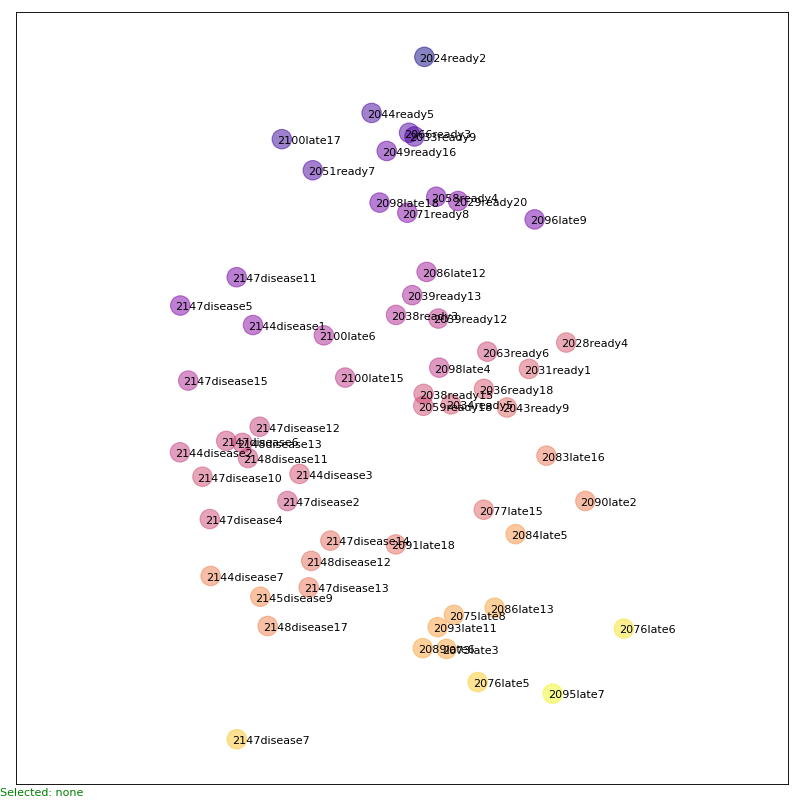

In [106]:
plot_ax = create_plot(df_2D)

In [34]:
point_attribute = create_checkbox()

interactive(children=(Checkbox(value=True, description='Toggle Titles'), Output()), _dom_classes=('widget-inte…

interactive(children=(Checkbox(value=False, description='Toggle Images'), Output()), _dom_classes=('widget-int…

##  Selected Points Details
Click the **Print** button below to display detailed data values of the points selected in the DR plot.  The selected points are Green.

In [35]:
dod = create_detail_display()

Button(description='Print selected points', style=ButtonStyle())

Output()

## Inverse Dimension Reduction
After selecting and/or dragging some points in the DR plot, click the **Learn** button to machine learn new dimension weights that would produce a plot with similar pairwise distances as your plot.  **Only the Green selected points** in the plot are considered when learning new weights. You must select or move at least two points to specify new desired distances. Use this to create your own clusters, and find out what makes some data points similar to or different from others.  The **learned weights** are shown in a bar chart below.

To see the effects of the learned weights, click the **Copy** button to apply the learned weights to the sliders and  make a new DR plot above.

Button(description='Retrain model with New Weights', style=ButtonStyle())

Button(description='Copy to Sliders', style=ButtonStyle())

<IPython.core.display.Javascript object>


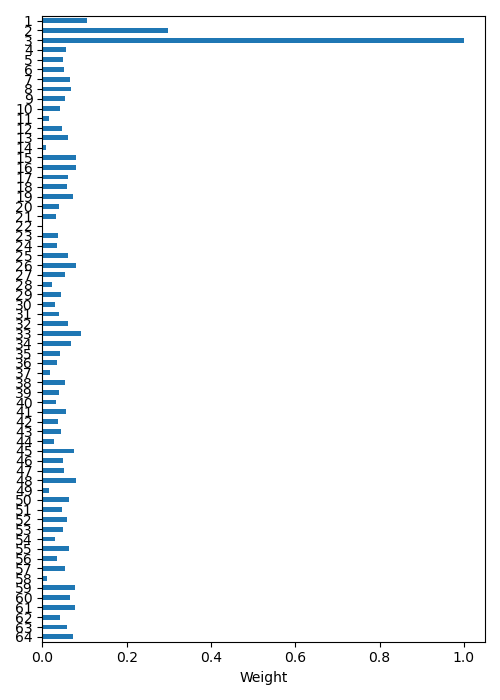

<IPython.core.display.Javascript object>


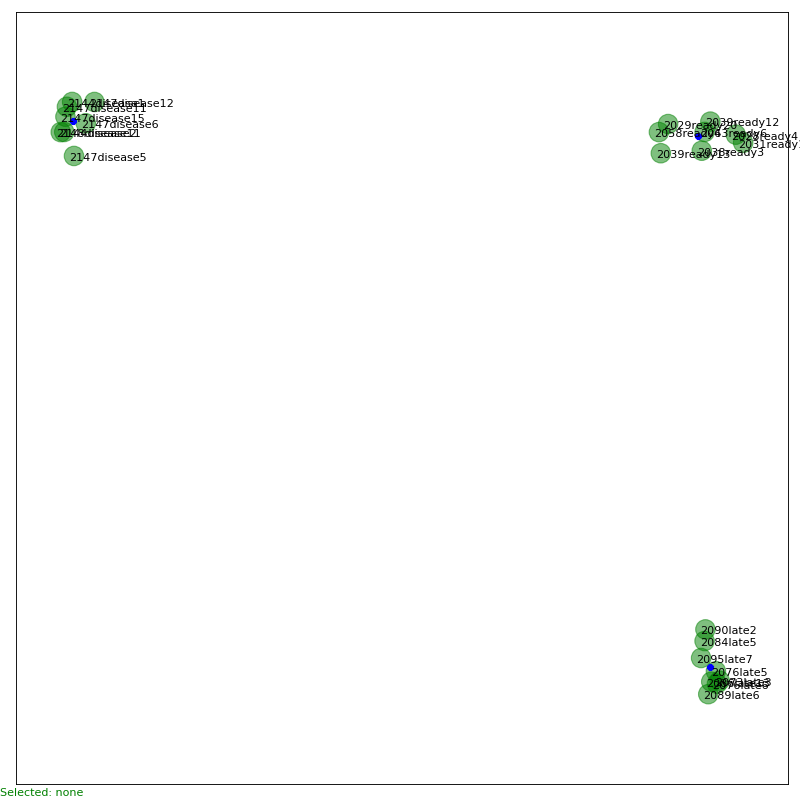

                      x         y
Image                            
2028ready4     0.012509  0.008591
2029ready20    0.010288  0.008939
2031ready1     0.012750  0.008324
2038ready3     0.011392  0.008064
2039ready12    0.011674  0.009019
2039ready13    0.010049  0.007982
2058ready4     0.009986  0.008675
2063ready6     0.011487  0.008680
2073late3      0.011979 -0.009324
2076late5      0.011856 -0.009015
2076late6      0.011890 -0.009422
2084late5      0.011484 -0.008023
2086late13     0.011704 -0.009356
2089late6      0.011605 -0.009766
2090late2      0.011512 -0.007641
2095late7      0.011371 -0.008580
2144disease1  -0.009265  0.009665
2144disease2  -0.009524  0.008679
2147disease11 -0.009437  0.009506
2147disease12 -0.008533  0.009664
2147disease15 -0.009485  0.009180
2147disease5  -0.009205  0.007892
2147disease6  -0.008818  0.008964
2148disease11 -0.009640  0.008674
                                Image_Path  Class
0      ./imagePreProcessing/2028ready4.png      2
1     ./imagePre

/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-08-24 00:17:50.245038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-24 00:17:51.109032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.3011 - val_accuracy: 0.6667 - 1s/epoch - 264ms/step
Epoch 2/30
5/5 - 1s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.7619 - val_accuracy: 0.6667 - 771ms/epoch - 154ms/step
Epoch 3/30
5/5 - 1s - loss: 3.3771e-04 - accuracy: 1.0000 - val_loss: 1.2673 - val_accuracy: 0.6667 - 829ms/epoch - 166ms/step
Epoch 4/30
5/5 - 1s - loss: 6.7421e-04 - accuracy: 1.0000 - val_loss: 1.1968 - val_accuracy: 0.6667 - 769ms/epoch - 154ms/step
Epoch 5/30
5/5 - 1s - loss: 7.3938e-04 - accuracy: 1.0000 - val_loss: 1.0537 - val_accuracy: 0.6667 - 806ms/epoch - 161ms/step
Epoch 6/30
5/5 - 1s - loss: 5.8167e-05 - accuracy: 1.0000 - val_loss: 1.0248 - val_accuracy: 0.6667 - 782ms/epoch - 156ms/step
Epoch 7/30
5/5 - 1s - loss: 1.6742e-05 - accuracy: 1.0000 - val_loss: 1.0715 - val_accuracy: 0.6667 - 788ms/epoch - 158ms/step
Epoch 8/30
5/5 - 1s - loss: 1.0030e-05 - accuracy: 1.0000 - val_loss: 1.1217 - val_accuracy: 0.6667 - 783ms/epoch - 157ms/step
Epoch 

<IPython.core.display.Javascript object>


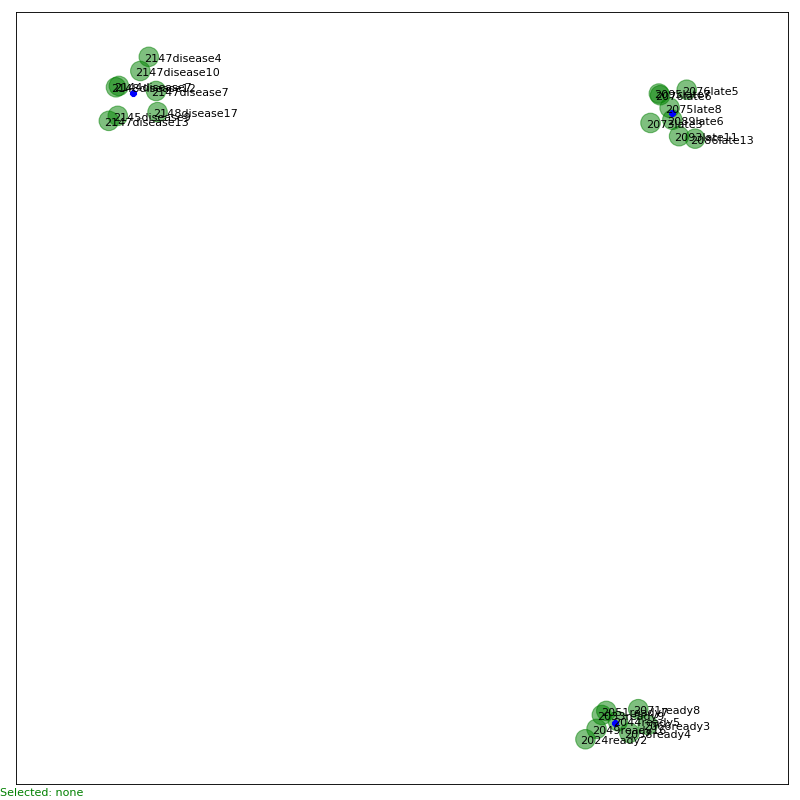

                      x         y
Image                            
2024ready2     0.007486 -0.014013
2033ready9     0.008194 -0.012963
2044ready5     0.008890 -0.013234
2049ready16    0.007966 -0.013565
2051ready7     0.008387 -0.012788
2058ready4     0.009382 -0.013739
2066ready3     0.010176 -0.013390
2071ready8     0.009768 -0.012713
2073late3      0.010296  0.012608
2075late8      0.011122  0.013264
2076late5      0.011860  0.014045
2076late6      0.010713  0.013804
2086late13     0.012221  0.011930
2089late6      0.011240  0.012746
2093late11     0.011530  0.012035
2095late7      0.010657  0.013878
2144disease7  -0.012668  0.014208
2145disease9  -0.012716  0.012916
2147disease10 -0.011740  0.014852
2147disease13 -0.013101  0.012699
2147disease4  -0.011374  0.015463
2147disease7  -0.011060  0.013989
2148disease12 -0.012793  0.014148
2148disease17 -0.010997  0.013074
                                Image_Path  Class
0      ./imagePreProcessing/2024ready2.png      2
1      ./imagePr

/Users/ritvikprabhu/miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-08-24 00:23:48.498887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-24 00:23:49.717926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 - 2s - loss: 2.2074 - accuracy: 0.7222 - val_loss: 1.0890 - val_accuracy: 0.8333 - 2s/epoch - 342ms/step
Epoch 2/30
5/5 - 1s - loss: 1.3968 - accuracy: 0.7778 - val_loss: 0.0590 - val_accuracy: 1.0000 - 788ms/epoch - 158ms/step
Epoch 3/30
5/5 - 1s - loss: 1.1700 - accuracy: 0.8333 - val_loss: 0.0069 - val_accuracy: 1.0000 - 785ms/epoch - 157ms/step
Epoch 4/30
5/5 - 1s - loss: 0.7192 - accuracy: 0.8333 - val_loss: 0.0122 - val_accuracy: 1.0000 - 776ms/epoch - 155ms/step
Epoch 5/30
5/5 - 1s - loss: 0.5207 - accuracy: 0.8889 - val_loss: 0.0837 - val_accuracy: 1.0000 - 780ms/epoch - 156ms/step
Epoch 6/30
5/5 - 1s - loss: 0.3539 - accuracy: 0.9444 - val_loss: 0.1717 - val_accuracy: 0.8333 - 784ms/epoch - 157ms/step
Epoch 7/30
5/5 - 1s - loss: 0.2928 - accuracy: 0.9444 - val_loss: 0.0690 - val_accuracy: 1.0000 - 786ms/epoch - 157ms/step
Epoch 8/30
5/5 - 1s - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 1.0000 - 857ms/epoch - 171ms/step
Epoch 8: early stopping
1     

In [108]:
inverse = create_inverse_button()